This Jupyter Notebook is used for extracting data from multiple sources. The sources include trip data, occupancy data, and parking lot data. 

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
import os
import folium
from pathlib import Path
import boto3

# import from src
os.chdir('../src')
from trips_data_retrieval import get_agg_trips_by_market, get_agg_trips
import inrix_data_science_utils.maps.quadkey as qkey

# set paths
data_path = Path('../data')

### Extracting Trips

In [3]:
# Change these as needed
# qk_list = ['02123003']  # seattle area
qk_list = ['021230032110033003', '021230032110033012', '021230032110033021', '021230032110033030']  # QFC North Bend
start_date = pd.to_datetime('2023-01-01 00:00:00')
end_date = pd.to_datetime('2023-06-30 00:01:00')
trip_type = 'dest'
filename_description = 'QFC_North_Bend'

# don't change these
start_year = str(start_date.year)
start_month = str(start_date.month).zfill(2)
start_day = str(start_date.day).zfill(2)
end_year = str(end_date.year)
end_month = str(end_date.month).zfill(2)
end_day = str(end_date.day).zfill(2)
out_filename = f'''trips_{start_year}-{start_month}-{start_day}_to_{
                end_year}-{end_month}-{end_day}{filename_description}.csv'''
out_file_path = data_path / out_filename
print('Will save the csv to ', out_file_path)
origin_qk = (trip_type == 'orig')

table_name = 'tripdata_na_restricted'
s3_tapp_data_dir = 'data-restricted'
s3_tapp_region = 'NA'

Will save the csv to  ..\data\trips_2023-01-01_to_2023-06-30QFC_North_Bend.csv


In [4]:
# if out_file_path not in the data folder, save it there
if not os.path.exists(out_file_path):
    df = get_agg_trips(
        agg_file_path = out_file_path,
        echo_query=True,
        table_name=table_name,
        start_date=start_date,
        end_date=end_date,
        qk_filter_list=qk_list,
        s3_tapp_data_dir=s3_tapp_data_dir,
        s3_tapp_region=s3_tapp_region,
        origin_qk=origin_qk,
    )
    print('Saved the csv to ', out_file_path)
else:
    df = pd.read_csv(out_file_path)

In [5]:
display(df)

,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving
0,2023,5,9,12,4,36,2123003211021130,2123003211003300,47.483290,-121.776148,47.493282,-121.780980,1,bc8ca58e3494c3c51013f6d943fe5e6f,1
1,2023,3,15,0,22,40,2123003211211013,2123003211003302,47.454651,-121.740032,47.492775,-121.780713,1,2b29375756044ba7bdd227c8c9f089cf,1
2,2023,5,19,19,29,20,2123003211122002,2123003211003300,47.470064,-121.728046,47.493163,-121.780790,1,3062d6f9c16509612a98fb526759e429,1
3,2023,1,14,22,49,18,2123003022002231,2123003211003300,47.608591,-122.334015,47.493202,-121.781222,1,324c223b87ff6e3b3982790329312022,1
4,2023,4,3,13,41,23,2123003211030110,2123003211003301,47.486475,-121.753957,47.493133,-121.780636,1,4b7fbaa9e3f94ae90e8c3d54f377de04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2023,4,13,19,31,25,2123003211003220,2123003211003302,47.489462,-121.791918,47.492970,-121.780951,1,1e71364d1997b5707899e41d54714297,1
11816,2023,3,20,21,7,7,2123003211030110,2123003211003302,47.486587,-121.753874,47.492730,-121.781418,1,ed14404a9cc7b9c5ab3e24d06462ab40,1
11817,2023,5,13,21,36,12,2123003211003210,2123003211003302,47.494398,-121.787044,47.493018,-121.780943,1,f78879a0549b5c433180a0c57783a3fb,1
11818,2023,5,13,17,33,12,2123003211003231,2123003211003303,47.490072,-121.784258,47.492469,-121.780279,1,9f960eb88c80b76a4f26486db8c12977,1


In [6]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
display(df)

,year,month,day,hour,minute,second,orig_qk17,dest_qk17,start_lat,start_lon,end_lat,end_lon,count,trip_id,is_moving,date
0,2023,5,9,12,4,36,2123003211021130,2123003211003300,47.483290,-121.776148,47.493282,-121.780980,1,bc8ca58e3494c3c51013f6d943fe5e6f,1,2023-05-09 12:04:36
1,2023,3,15,0,22,40,2123003211211013,2123003211003302,47.454651,-121.740032,47.492775,-121.780713,1,2b29375756044ba7bdd227c8c9f089cf,1,2023-03-15 00:22:40
2,2023,5,19,19,29,20,2123003211122002,2123003211003300,47.470064,-121.728046,47.493163,-121.780790,1,3062d6f9c16509612a98fb526759e429,1,2023-05-19 19:29:20
3,2023,1,14,22,49,18,2123003022002231,2123003211003300,47.608591,-122.334015,47.493202,-121.781222,1,324c223b87ff6e3b3982790329312022,1,2023-01-14 22:49:18
4,2023,4,3,13,41,23,2123003211030110,2123003211003301,47.486475,-121.753957,47.493133,-121.780636,1,4b7fbaa9e3f94ae90e8c3d54f377de04,1,2023-04-03 13:41:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2023,4,13,19,31,25,2123003211003220,2123003211003302,47.489462,-121.791918,47.492970,-121.780951,1,1e71364d1997b5707899e41d54714297,1,2023-04-13 19:31:25
11816,2023,3,20,21,7,7,2123003211030110,2123003211003302,47.486587,-121.753874,47.492730,-121.781418,1,ed14404a9cc7b9c5ab3e24d06462ab40,1,2023-03-20 21:07:07
11817,2023,5,13,21,36,12,2123003211003210,2123003211003302,47.494398,-121.787044,47.493018,-121.780943,1,f78879a0549b5c433180a0c57783a3fb,1,2023-05-13 21:36:12
11818,2023,5,13,17,33,12,2123003211003231,2123003211003303,47.490072,-121.784258,47.492469,-121.780279,1,9f960eb88c80b76a4f26486db8c12977,1,2023-05-13 17:33:12


In [7]:
print(len(df['date'].unique()), 'unique timestamps')

11810 unique timestamps


In [8]:
m = folium.Map(zoom_start=10)

N = 11
for i in range(0, df.shape[0], N):
    folium.CircleMarker(
        location=[
            df['end_lat'].values[i],
            df['end_lon'].values[i]
        ],
        color='red',
        radius=1
    ).add_to(m)
m.fit_bounds(m.get_bounds())

m

### Extract the 6 Flags Polygon Shapes

In [9]:
from polygon_retrieval import get_polygons

In [10]:
# Six Flags
brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
poly_file_name = data_path / 'six_flags_polygons.csv'

In [12]:
if not os.path.exists(poly_file_name):
    polygon_df = get_polygons(brand_id, format='df', echo_query=True)
    relevant_cols = ['location_name', 'top_category', 'sub_category', 'latitude', 'longitude', 'street_address', 'city', 'region', 'postal_code', 'open_hours',
                 'category_tags', 'polygon_wkt', 'polygon_class', 'enclosed', 'is_synthetic', 'includes_parking_lot', 'wkt_area_sq_meters', 'tz', 'year',
                 'month', 'pg_id', 'parking_wkt']
    polygon_df = polygon_df[relevant_cols]
    polygon_df.to_csv(poly_file_name, index=False)
else:
    polygon_df = pd.read_csv(poly_file_name)


        select poi.*, prk.polygon_wkt as parking_wkt
        from sg_poi.poi_staging_pg_partitions_202404 poi
        join sg_poi.parking_staging_pg_partitions prk on poi.placekey = prk.related_poi[1]
        where cardinality(related_poi) > 0 and cardinality(brands) > 0
        and brands[1].safegraph_brand_id = 'SG_BRAND_0dd52fbf1cd77fc38e06650435ada07d'
    
Query executed successfully.


In [54]:
# display all the columns of the polygon_df
pd.set_option('display.max_columns', None)
display(polygon_df.head(3))

,location_name,top_category,sub_category,latitude,longitude,street_address,city,region,postal_code,open_hours,category_tags,polygon_wkt,polygon_class,enclosed,is_synthetic,includes_parking_lot,wkt_area_sq_meters,tz,year,month,pg_id,parking_wkt
0,Six Flags,Amusement Parks and Arcades,Amusement and Theme Parks,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY,12804,"{mon=[[10:30, 19:00]], tue=[[10:30, 19:00]], w...","[Playground, Tubing, Water Park]",POLYGON ((-73.69653869904636 43.35259971347597...,OWNED_POLYGON,False,False,True,564689,America/New_York,2024,04,3011,"POLYGON ((-73.6955239 43.3518867, -73.695232 4..."
1,Six Flags,Amusement Parks and Arcades,Amusement and Theme Parks,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY,12804,"{mon=[[10:30, 19:00]], tue=[[10:30, 19:00]], w...","[Playground, Tubing, Water Park]",POLYGON ((-73.69653869904636 43.35259971347597...,OWNED_POLYGON,False,False,True,564689,America/New_York,2024,04,3011,POLYGON ((-73.69490421999996 43.35225319100004...
2,Six Flags,Amusement Parks and Arcades,Amusement and Theme Parks,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY,12804,"{mon=[[10:30, 19:00]], tue=[[10:30, 19:00]], w...","[Playground, Tubing, Water Park]",POLYGON ((-73.69653869904636 43.35259971347597...,OWNED_POLYGON,False,False,True,564689,America/New_York,2024,04,3011,"POLYGON ((-73.694096 43.3507648, -73.6950243 4..."


In [15]:
# make a new df with just the unique latitude and longitude columns
store_locations_df = polygon_df[['latitude', 'longitude', 'street_address', 'city', 'region']].drop_duplicates()
display(store_locations_df)

,latitude,longitude,street_address,city,region
0,43.350715,-73.689007,89 Six Flags Dr,Queensbury,NY
53,42.369309,-87.935103,542 N State Route 21,Gurnee,IL
76,38.906271,-76.776467,13710 Central Ave,Bowie,MD
148,40.141007,-74.438164,1 Six Flags Blvd,Jackson,NJ
334,32.761690,-97.081166,1800 E Lamar Blvd,Arlington,TX
355,35.463453,-97.589371,3908 W Reno Ave,Oklahoma City,OK
359,42.927651,-78.385383,9993 Alleghany Rd,Corfu,NY
403,42.245289,-88.964116,7820 Cherryvale N Blvd,Cherry Valley,IL


In [16]:
six_flag_stores = folium.Map(zoom_start=15)
for i, row in store_locations_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        color='blue',
        radius=4
    ).add_to(six_flag_stores)
six_flag_stores.fit_bounds(six_flag_stores.get_bounds())
six_flag_stores

#### Map the parking lots at each store

epsg:4326


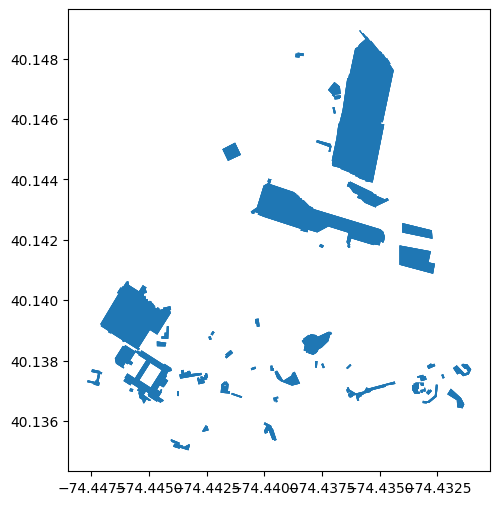

In [59]:
lot_gpd = polygon_df.copy()
geometry = lot_gpd['parking_wkt'].apply(wkt.loads)
lot_gpd = gpd.GeoDataFrame(lot_gpd, crs='epsg:4326', geometry=geometry)
print(lot_gpd.crs)
lot_gpd[lot_gpd['city'] == 'Jackson'].plot(figsize=(6, 6))
plt.show()

In [61]:
for i, row in lot_gpd.iterrows():
    x = row['geometry']
    print(type(x), x)

<class 'shapely.geometry.polygon.Polygon'> POLYGON ((-73.6955239 43.3518867, -73.695232 43.3516518, -73.696134 43.3510237, -73.69638999999999 43.3511403, -73.696 43.3513961, -73.6959761 43.3515735, -73.6955239 43.3518867))
<class 'shapely.geometry.polygon.Polygon'> POLYGON ((-73.69490421999996 43.35225319100005, -73.69490235999996 43.35222139000007, -73.69472803699995 43.35222681700003, -73.69499039999999 43.3520039, -73.69512570000001 43.3521264, -73.69549859999999 43.3523473, -73.69543229999999 43.3524357, -73.69528870000001 43.3524739, -73.6946727 43.3525522, -73.6944932 43.3524015, -73.69475604499996 43.35225780600007, -73.69490421999996 43.35225319100005))
<class 'shapely.geometry.polygon.Polygon'> POLYGON ((-73.694096 43.3507648, -73.6950243 43.3505004, -73.6947874 43.3501524, -73.6939381 43.3504395, -73.694096 43.3507648))
<class 'shapely.geometry.polygon.Polygon'> POLYGON ((-73.6940487 43.3520794, -73.6941635 43.3519716, -73.6941085 43.3519194, -73.69442429999999 43.3516532, -7

In [84]:
lot_map = folium.Map(zoom_start=10)
cities = lot_gpd['city'].unique()
# add pois to lot map
for city in cities:
    city_gpd = lot_gpd[lot_gpd['city'] == city].copy()
    geom = city_gpd['polygon_wkt'].values[0]
    # convert geom to a shapely geometry object
    geom = wkt.loads(geom)
    # print(type(geom), geom)
    sim_geo = gpd.GeoSeries(geom) #.simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'red', 'color': 'red', 'opacity': 0.3})
    folium.Popup(city).add_to(geo_j)
    geo_j.add_to(lot_map)

# add parking lots to lot map
for _, r in lot_gpd.iterrows():
    geom = r['geometry']
    sim_geo = gpd.GeoSeries(geom)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'opacity': 0.8})
    geo_j.add_to(lot_map)
print('loop done')
lot_map

loop done
